# Analysis Of Airbnb Data ...
### What do people look for in the listing advertisement?
#### Reviews (score review, positive, negative)
### When are the peak listing times for my property?
#### 
### How should I price my property?
### How much should I increase my weekend/holiday price

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar as us_calendar

%matplotlib inline

## 1.0 Load and Examine Data

### 1.1 Load data
* **`calendar.csv`**:
   * `date`: load in pandas as DateTime
   * `available`: convert **'t' / 'f'** ==> **1 / 0**
   * `price`: convert to float

In [2]:
# Load data

# Reformat data on loading
price_format = lambda s: np.nan if not s else float(s.replace('$', '').replace(',', ''))
tf_format = lambda s: 1 if s == 't' else 0

calendar = pd.read_csv('./data/boston/calendar.csv',
                       parse_dates=['date'], infer_datetime_format=True,
                       converters={'price': price_format, 'available': tf_format})

calendar.sample(5)

,listing_id,date,available,price
1241608,6923942,2016-12-13,0,NaN
1107796,12593869,2017-04-05,1,31.0
1154304,4863108,2017-01-10,1,93.0
662255,25418,2017-03-21,1,249.0
1036025,13564281,2017-04-01,0,NaN


### 1.2 Examine Data

In [3]:
calendar.describe()

,listing_id,available,price
count,1.308890e+06,1.308890e+06,643037.000000
mean,8.442118e+06,4.912842e-01,198.438909
std,4.500149e+06,4.999242e-01,180.142913
min,3.353000e+03,0.000000e+00,11.000000
25%,4.679319e+06,0.000000e+00,85.000000
50%,8.578710e+06,0.000000e+00,150.000000
75%,1.279603e+07,1.000000e+00,255.000000
max,1.493346e+07,1.000000e+00,7163.000000


In [4]:
calendar.date.describe()

count                 1308890
unique                    365
top       2016-12-27 00:00:00
freq                     3586
first     2016-09-06 00:00:00
last      2017-09-05 00:00:00
Name: date, dtype: object

In [5]:
# Examine data
print(f'Collected data is from {calendar.date.min()} and {calendar.date.max()} '
      f'with {calendar.shape[0]} entries\n')
print(f'Percent of Missing Column Values:\n{round(calendar.isna().mean() * 100, 2)}\n', )
print(f'There are a total of {calendar.shape[0]} listings with '
      f'{calendar.listing_id.nunique()} unique listing_ids\n')

# check aif missing any listings were available for dates where price is missing
is_missing_price_not_availbale = pd.Series((calendar.available == 0) == (calendar.price.isna())).all()
print(f'All listings with missing prices correspond to *not* available and vice versa: '
      f'{is_missing_price_not_availbale}')

Collected data is from 2016-09-06 00:00:00 and 2017-09-05 00:00:00 with 1308890 entries

Percent of Missing Column Values:
listing_id     0.00
date           0.00
available      0.00
price         50.87
dtype: float64

There are a total of 1308890 listings with 3585 unique listing_ids

All listings with missing prices correspond to *not* available and vice versa: True


Note that even though there are 3585 unique listing_ids and 365 unique dates, the total number of rows is 365 values larger than 365 * 3585 = 1308525. Suggesting that there are duplicate entries. Let's check for the duplicates:

In [6]:
# Duplicate
calendar[calendar.duplicated(keep=False)].sort_values(['listing_id', 'date'])

,listing_id,date,available,price
748850,12898806,2016-09-06,1,220.0
748873,12898806,2016-09-06,1,220.0
748849,12898806,2016-09-07,1,220.0
748872,12898806,2016-09-07,1,220.0
748848,12898806,2016-09-08,1,220.0
...,...,...,...,...
748853,12898806,2017-09-03,0,NaN
748498,12898806,2017-09-04,0,NaN
748852,12898806,2017-09-04,0,NaN
748497,12898806,2017-09-05,0,NaN


Above shows that we indeed have duplicated entries for `listing_id = 12898806`, we will drop the duplicate entires in the section 2.1 below.

Let's examine the distribution of listing prices:

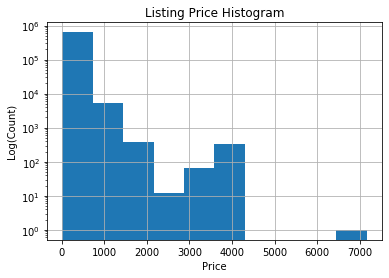

In [7]:
ax1 = calendar.price.hist(log=True)
ax1.set_title('Listing Price Histogram')
ax1.set_xlabel('Price')
ax1.set_ylabel('Log(Count)');

As seen from the plot, there apper to be some outliers which we will deal with in the section 2.3 below.

## 2.0 Clean Data
 * **Duplicates**
 * **Calendar Dates**
 * **Missing values**
 * **Outliers**
 
### 2.1 Duplicates
Let's remove the duplicate rows found above and store our clean calendar dataframe as **`cal_clean`**:

In [8]:
calendar = calendar.drop_duplicates()

### 2.2 Calendar Dates

In [27]:
# Engineer US holiday calendar related features

# Add day of week
calendar['day_of_week'] = calendar.date.dt.dayofweek  # Monday = 0, ..., Sunday = 6

# Add weekend
# Sat or Sunday ==> 1
# Monday - Friday ==> 0
calendar['weekend'] = calendar.day_of_week.apply(lambda s: 1 if s >= 5 else 0)

# Add holiday
# US holidays ==> 1
# Non holidays ==> 0
cal = us_calendar()
holidays = cal.holidays(start=calendar.date.min(), end=calendar.date.max())
calendar['holiday'] = calendar['date'].isin(holidays).astype(int)
calendar['day_num'] = (calendar['date'] - calendar['date'].min()).dt.days

calendar.head()

,listing_id,date,available,price,day_of_week,weekend,holiday,price_listing_mean,price_listing_adj,day_num
365,3075044,2017-08-22,1,65.0,1,0,0,67.81337,-0.041487,350
366,3075044,2017-08-21,1,65.0,0,0,0,67.81337,-0.041487,349
367,3075044,2017-08-20,1,65.0,6,1,0,67.81337,-0.041487,348
368,3075044,2017-08-19,1,75.0,5,1,0,67.81337,0.105977,347
369,3075044,2017-08-18,1,75.0,4,0,0,67.81337,0.105977,346


### 2.2 Missing values
Investigate whether we can safely remove some of the missing price rows. Note that since listing availability maps 1:1 with missing price data. Consequently, we have to be careful about dropping missing price rows since dropped availability data may skew seasonal and cumulative availability patterns. However, listings that are not available for the entire data time interval carry no information useful for our analysis and can be dropped.

In [28]:
# Find listings with 0 availability for the entire year and drop rows for these listings
listing_availability = calendar.groupby(['listing_id'])['available'].sum().reset_index()\
        .rename(columns={'listing_id': 'listing_id', 'available': 'total_available'})
listing_availability.sample(5, random_state=42)

,listing_id,total_available
141,508017,298
1208,7134081,337
486,2683284,344
1720,9921925,170
1740,10033322,179


In [29]:
never_available_listings = listing_availability[listing_availability.total_available == 0]\
        .listing_id.values
calendar = calendar[~calendar.listing_id.isin(never_available_listings)]  # drop never available
print('After dropping never available listings, there '
      f'remain {calendar.shape[0]} entries '
      f'with {calendar.listing_id.nunique()} unique listing_id\'s')

After dropping never available listings, there remain 1060690 entries with 2906 unique listing_id's


### 2.3 Outliers

Before we search for outliers in our data, we should consider that listing prices can vary significantly from listing to listing, possibly hiding listing specific outliers in the cumulative data set. Thus, to avoid this loss of information, instead of examining raw prices, we will engineer a column  
  
**`price_listing_adj`** = `(price - median) / median`, where  
`median = median price for each lisiting_id`.

Note that we chose median vs. more common mean value since outliers can significantly skew the mean value. Additionally, we chose to use percent deviation rather than normalization or standardization for ease of interpretation.

In [30]:
# Calculate mean listing price
calendar['price_listing_mean'] = calendar.groupby(['listing_id'])['price'].transform('mean')

# Engineer listing_id mean adjusted price: (price - median) / median
calendar['price_listing_adj'] = ((calendar.price - calendar.price_listing_mean) 
                                  / calendar.price_listing_mean)

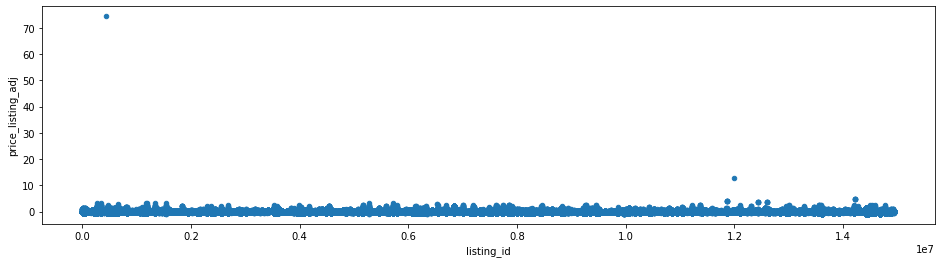

In [31]:
ax2 = calendar.plot(x='listing_id', y='price_listing_adj', figsize=(16, 4), kind='scatter');

There are a few clear outliers, but let's zoom in closer

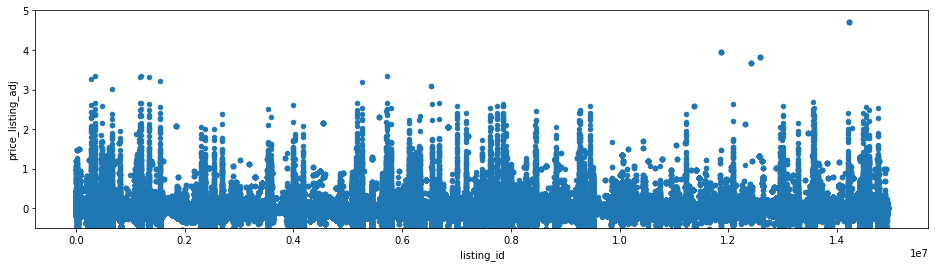

In [32]:
ax2 = calendar.plot(x='listing_id', y='price_listing_adj', figsize=(16, 4), kind='scatter');
ax2.set_ylim(-0.5, 5);

In [34]:
colors = np.where(calendar['weekend']==1,'r','b')
colors

array(['b', 'b', 'r', ..., 'b', 'b', 'b'], dtype='<U1')

AttributeError: module 'pandas' has no attribute 'td'

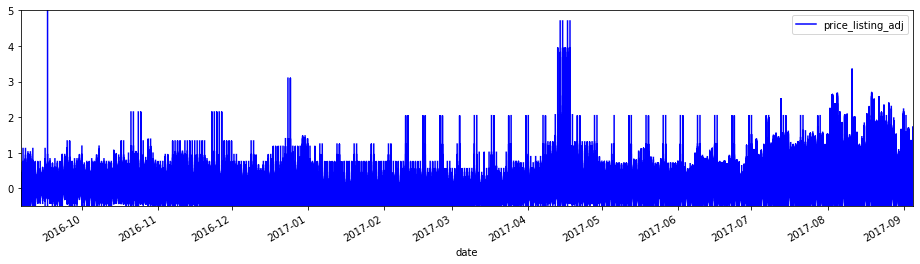

In [41]:
ax4 = calendar.plot(x='date', y='price_listing_adj', figsize=(16, 4), color=colors);
ax4.set_ylim(-0.5, 5)
ax4.set_xlim(pd.td.dt('2017-02-01'), pd.td.dt('2017-04-01'))

There appear to be some listings with large spread of prices. Lets take a closer look at these.

In [ ]:
listings_large_spread = cal_clean[cal_clean.price_listing_adj > 2].listing_id.unique()
print(f'Number of listings deviating more than 2x from median listing price is: '
      f'{len(listings_large_spread)}')

In [ ]:
cal_large_spread = cal_clean[cal_clean.listing_id.isin(listings_large_spread)]
cal_large_spread['day_num'] = (cal_large_spread['date'] - cal_large_spread['date'].min()).dt.days

In [ ]:
cal_large_spread

In [ ]:
ax3 = cal_large_spread.plot(x='day_num', y='price_listing_adj', figsize=(16, 4), kind='scatter');

In [ ]:
# pick five unique id's
large_spread_listing_ids = np.random.choice(cal_large_spread.listing_id.unique(), 5)
cal_large_spread_sample = cal_clean[cal_clean.listing_id.isin(large_spread_listing_ids)]

In [ ]:
fg = sns.FacetGrid(data=cal_large_spread_sample, hue='listing_id', aspect=16/4)
fg.map(plt.scatter, 'date', 'price_listing_adj').add_legend()

In [ ]:
# Examine price distributions
# Investigate patterns in the amount of missing data in each column
ax1 = calendar.price.plot.hist()
ax1.set(yscale='log');

Looks like there are outliers in the price

In [ ]:
# Examine high priced > $1000
high_priced = calendar[calendar.price >= 1000]
ax2 = high_priced.price.plot.hist()
ax2.set(yscale='log');

In [ ]:
# Compare weekend vs. holiday vs. weekday prices
calendar['price_listing_mean'] = calendar.groupby(['listing_id'])['price'].transform('mean')

# Engineer listing_id mean adjusted price
calendar['price_dev_listing_mean'] = (calendar.price - calendar.price_listing_mean) / calendar.price_listing_mean

In [ ]:
# Availability by date
calendar['available_total'] = calendar.groupby(['date'])['available'].transform('sum')

In [ ]:
calendar

In [ ]:
calendar.sample(10)

In [ ]:
calendar.price_listing_mean.isna().value_counts()

In [ ]:
calendar.plot(y='price', x='available_total', style='o')